# Sistemas de recomendación
### Carga de datos de Movie Lens

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd

In [60]:
df = pd.read_csv("/content/drive/MyDrive/Python Machine Learning JGG/datasets/ml-100k/u.data.csv", sep="\t", header=None)

In [61]:
df.head()

,0,1,2,3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [62]:
df.shape

(100000, 4)

In [63]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
#nombramos a las columnas de esta manera:

In [64]:
df.columns = ["UserID", "ItemID", "Rating", "TimeStamp"]

In [65]:
df.head()

,UserID,ItemID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


### Análisis exploratorio de los ítems

In [66]:
import matplotlib.pyplot as plt

(array([ 6110.,     0., 11370.,     0.,     0., 27145.,     0., 34174.,
            0., 21201.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

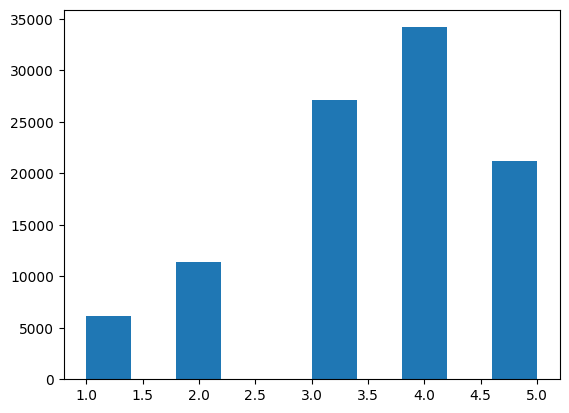

In [67]:
plt.hist(df.Rating)

(array([11459.,  5724., 19359.,  9315.,  9396., 10083.,  6175.,  9603.,
        10048.,  8838.]),
 array([8.74724710e+08, 8.76580903e+08, 8.78437096e+08, 8.80293288e+08,
        8.82149481e+08, 8.84005674e+08, 8.85861867e+08, 8.87718060e+08,
        8.89574252e+08, 8.91430445e+08, 8.93286638e+08]),
 <BarContainer object of 10 artists>)

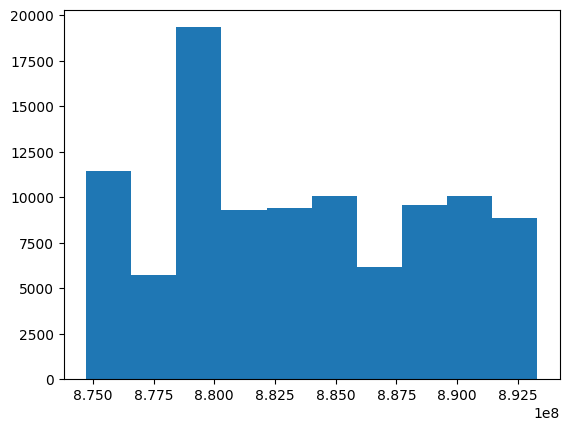

In [68]:
plt.hist(df.TimeStamp)   #### si leeemos el readme, veremos que va de 1995 hasta 2015

In [69]:
df.groupby(["Rating"])["UserID"].count()    ## este es en realidad el primer histograma que hemos hecho

Rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: UserID, dtype: int64

In [70]:
df.groupby(["ItemID"])["ItemID"].count()   #me muestra cuanta gente ha visto la peli 1, cuanta la 2,....

ItemID
1       452
2       131
3        90
4       209
5        86
       ... 
1678      1
1679      1
1680      1
1681      1
1682      1
Name: ItemID, Length: 1682, dtype: int64

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <BarContainer object of 10 artists>)

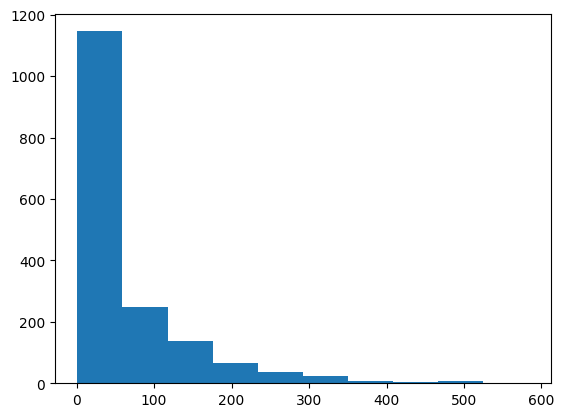

In [71]:
plt.hist(df.groupby(["ItemID"])["ItemID"].count())

In [ ]:
# este histograma nos indica que hay peliculas más vistas que otras

### Representación en forma matricial

In [72]:
import numpy as np

In [ ]:
# para ofrecer un sistema de recomendaciones necesitamos una matriz de valoraciones:

In [ ]:
# cada fila sera un usuario y cada columna la pelicula, y el dato será la nota

In [73]:
n_users = df.UserID.unique().shape[0]     # hay 943 usuarios
n_users

943

In [74]:
n_items = df.ItemID.unique().shape[0]   # hay 1682 pelis
n_items

1682

In [75]:
ratings = np.zeros((n_users, n_items))

In [76]:
for row in df.itertuples():    # por cada fila
    ratings[row[1]-1, row[2]-1] = row[3]    #row en la columna 1 menos 1 (empezamos en 0 y los usuarios del dataset empiezan en 1); row en la columna 2 menos 1 (que es la peli)= row en la columna 3 que es el rating

In [77]:
type(ratings)

numpy.ndarray

In [78]:
ratings.shape

(943, 1682)

In [79]:
ratings

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

In [ ]:
# podemos saber que cantidad de datos no son cero (coeficiente de sparseidad) haciendo esto:

In [80]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0]*ratings.shape[1])    #numero de filas x numero de columnas
sparsity *= 100
print("Coeficiente de sparseidad: {:4.2f}%".format(sparsity))

Coeficiente de sparseidad: 6.30%


In [ ]:
# es decir, solo el 6.3% de los datos no es cero. El cero es ausencia de valores. desconocemos el 94%.

### Crear conjuntos de entrenamiento y validación

In [81]:
from sklearn.model_selection import train_test_split

In [82]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.3, random_state=42)

In [83]:
ratings_train.shape

(660, 1682)

In [84]:
ratings_test.shape

(283, 1682)

## Filtro colaborativo basado en Usuarios
* Matriz de similaridad entre los usuarios (distancia del coseno).   (trato de buscar usuarios con gustos parecidos)
* Predecir la valoración desconocida de un ítem *i* para un usuario activo *u* basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
* Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [85]:
import numpy as np
import sklearn

In [86]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_train)   #ojo, la distancia me va a dar entre 0 y 1, el problema es que un coseno = 0, indica que la distancia es nula, es decir, que los usuarios son lo más parecido posible, mientras que la similiradidad es lo contrario. Por ello ponemos 1 - ....

In [87]:
type(sim_matrix)

numpy.ndarray

In [88]:
sim_matrix.shape

(660, 660)

In [89]:
sim_matrix   # da una matriz simetrica, la diagonal ppal es 1 porque cada usuario esta infinitamente cerca de sí mismo

array([[1.        , 0.17448349, 0.18009754, ..., 0.13331459, 0.17695593,
        0.21882481],
       [0.17448349, 1.        , 0.07993097, ..., 0.07175808, 0.09552622,
        0.05512655],
       [0.18009754, 0.07993097, 1.        , ..., 0.0191736 , 0.02233385,
        0.10310785],
       ...,
       [0.13331459, 0.07175808, 0.0191736 , ..., 1.        , 0.04853428,
        0.05142508],
       [0.17695593, 0.09552622, 0.02233385, ..., 0.04853428, 1.        ,
        0.1198022 ],
       [0.21882481, 0.05512655, 0.10310785, ..., 0.05142508, 0.1198022 ,
        1.        ]])

In [90]:
users_predictions = sim_matrix.dot(ratings_train) / np.array([np.abs(sim_matrix).sum(axis=1)]).T    #   .dot = producto matricial; pondero por todos los usarios de la misma fila y traspongo (.T)

In [91]:
users_predictions    #estas son las notas de cada usuario

array([[2.10259747e+00, 5.86975978e-01, 3.40264192e-01, ...,
        0.00000000e+00, 7.33611460e-03, 6.04379414e-03],
       [1.40999723e+00, 2.91863934e-01, 2.68085289e-01, ...,
        0.00000000e+00, 3.50378592e-03, 2.32963985e-03],
       [1.69014833e+00, 3.13648440e-01, 3.26127887e-01, ...,
        0.00000000e+00, 3.25391767e-03, 1.77210119e-03],
       ...,
       [1.73393747e+00, 4.06719333e-01, 3.21166908e-01, ...,
        0.00000000e+00, 2.71269625e-03, 9.00511411e-03],
       [2.34361031e+00, 8.10544770e-01, 4.73941025e-01, ...,
        0.00000000e+00, 1.01130066e-02, 9.66427605e-03],
       [2.36796969e+00, 5.98146138e-01, 3.85569804e-01, ...,
        0.00000000e+00, 6.39996638e-03, 5.37442746e-03]])

In [92]:
users_predictions.shape   # hay 660 usuarios con la nota para cada peli

(660, 1682)

In [93]:
# vamos a definir una funcion para hallar el error cuadratico (o la performance). usamos el error cuadratico medio, restando por un lado las predicciones a los valores originales que no fueran cero. 
# el valor 0 original era la ausencia de conocimiento. solo voy a restar para los valores conocidos para ver si la predicción se ajusta a la realidad

In [94]:
from sklearn.metrics import mean_squared_error

In [95]:
def get_mse(preds, actuals):
    if preds.shape[0] != actuals.shape[0]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()     #.flatten: para pasarlo a vector
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)

In [96]:
get_mse(users_predictions, ratings_train)

7.878218313143215

In [ ]:
# error cuadratico medio de 7.87. en realidad es un error alto, ya que los rating van de 0 a 10; por qué sale error tan alto? porque hemos considerado a todos los usarios. por ello, es mejor usar solo a los más cercanos. por eso usaremos más abajo lo k nearest neighbors

In [ ]:
# ahora lo hacemos para el rating_test

In [97]:
sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings_test)
users_predictions = sim_matrix.dot(ratings_test) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
get_mse(users_predictions, ratings_test)

7.51355110112698

## Filtro colaborativo basado en los KNN

In [98]:
from sklearn.neighbors import NearestNeighbors

In [108]:
k = 10

In [116]:
neighbors = NearestNeighbors()

In [117]:
neighbors.fit(ratings_train)

NearestNeighbors()

In [118]:
neighbors

NearestNeighbors()

In [119]:
top_k_distances, top_k_users = neighbors.kneighbors(ratings_train, return_distance=True)

In [120]:
top_k_distances.shape

(660, 5)

In [121]:
top_k_distances[0]   # esto indica distancias, si es 0 es que están encima

array([ 0.        , 41.71330723, 43.3474336 , 45.04442252, 45.04442252])

In [122]:
top_k_users.shape

(660, 5)

In [123]:
top_k_users[0]

array([  0, 211,  16, 583, 428])

In [ ]:
# lo siguiente será elegir, de todos esos usuarios, y debido a la cercanía, solo será la valracion de lso mismos lo que se tendrsá que tener en cuenta ponderando todas las valoraciones

In [125]:
users_predicts_k = np.zeros(ratings_train.shape)
for i in range(ratings_train.shape[0]):# para cada usuario del conjunto de entrenamiento
    users_predicts_k[i,:] = top_k_distances[i].T.dot(ratings_train[top_k_users][i]) / np.array([np.abs(top_k_distances[i].T).sum(axis=0)]).T   ###desde / np.array lo usamos para normalizar

In [126]:
users_predicts_k.shape

(660, 1682)

In [127]:
users_predicts_k  

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.74469557, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.9753676 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# vamos a ver si el metodo ha mejorado o no

In [130]:
get_mse(users_predicts_k, ratings_train)

8.184923775834722

In [ ]:
# no se ha mejorado nada la verdad....

## Filtro colaborativo basado en Items

In [148]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [150]:
neighbors = NearestNeighbors()

In [151]:
neighbors.fit(ratings_train.T)

NearestNeighbors()

In [158]:
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [159]:
top_k_distances.shape

(1682, 5)

In [154]:
top_k_distances

array([[ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757],
       [ 0.        , 27.        , 27.29468813, 27.29468813, 27.34958866],
       [ 0.        , 24.77902339, 25.05992817, 25.45584412, 25.47547841],
       ...,
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  3.        ,  3.        ,  3.        ],
       [ 0.        ,  1.        ,  3.        ,  3.        ,  3.        ]])

In [160]:
top_k_items.shape

(1682, 5)

In [161]:
top_k_items

array([[   0,  120,  404,  116,  221],
       [   1,  575,  232,   28,  230],
       [   2,  742, 1094, 1214, 1418],
       ...,
       [1504, 1121, 1481, 1509, 1506],
       [1680, 1671, 1506, 1481, 1121],
       [1681, 1596, 1506, 1481, 1121]])

In [162]:
item_preds = ratings_train.dot(top_k_distances) / np.array([np.abs(top_k_distances).sum(axis=1)])

ValueError: ignored

### Filtrado colaborativo basado en KNN

In [ ]:
# hasta ahora nos hemos basado en comparar usuarios y buscar los mas parecido y ponderar las decisiones de esos usuarios para recomendar o no un determinado item de la coleccion.
# el sistema de filtro colaborativo basado en items, es similar basado en usuarios, con un par de cambios en como se usa la matriz de valoracion.
# el primera paso tambien es calcular las similaridades, pero no entre usuarios si no entre peliculas
# como tenemos que calcular similaridades entre pelis, vamos a usar un contador n_movies apra establecer el numero de peliculas que tenemos

In [132]:
n_movies = ratings_train.shape[1]
n_movies

1682

In [136]:
k = 30
neighbors = NearestNeighbors()
neighbors.fit(ratings_train.T)
top_k_distances, top_k_items = neighbors.kneighbors(ratings_train.T, return_distance=True)

In [137]:
top_k_distances.shape

(1682, 5)

In [166]:
top_k_items[0]

array([  0, 120, 404, 116, 221])

In [139]:
top_k_distances[0]

array([ 0.        , 53.12249994, 54.38749856, 55.50675635, 56.49778757])

In [140]:
preds = np.zeros(ratings_train.T.shape)
for i in range(ratings_train.T.shape[0]):
    if(i%50==0):
        print("iter "+str(i))
    den = 1
    if (np.abs(top_k_distances[i]).sum(axis=0)>0):
        den = np.abs(top_k_distances[i]).sum(axis=0)
    preds[i, :] = top_k_distances[i].dot(ratings_train.T[top_k_items][i])/np.array([den]).T

iter 0
iter 50
iter 100
iter 150
iter 200
iter 250
iter 300
iter 350
iter 400
iter 450
iter 500
iter 550
iter 600
iter 650
iter 700
iter 750
iter 800
iter 850
iter 900
iter 950
iter 1000
iter 1050
iter 1100
iter 1150
iter 1200
iter 1250
iter 1300
iter 1350
iter 1400
iter 1450
iter 1500
iter 1550
iter 1600
iter 1650


In [141]:
get_mse(preds, ratings_train)

7.579104577886427

In [142]:
get_mse(preds, ratings_test)

11.384459397502267

In [143]:
preds.shape

(1682, 660)

In [144]:
ratings_train.shape

(660, 1682)

In [145]:
ratings_test.shape

(283, 1682)